In [ ]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
from PIL import Image
import numpy as np
def show_pnm(file_name):
    with open(file_name, 'r') as f:
        vals = f.read().split()
    w = int(vals[1])
    h = int(vals[2])
    if vals[0] == 'P2': # Grayscale
        pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
    elif vals[0] == 'P3': # RGB
        pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
    else:
        return None
    return Image.fromarray(pixels)
    
def convertImgtoPnm(fileName:str,outName:str):
  img =np.array( Image.open(fileName))
  h,w,_=img.shape
  with open(outName, 'w') as f:
      f.write("P3\n")
      f.write("{} {}\n".format(img.shape[1],img.shape[0]))
      f.write("255\n")
      for i in range(h):
        for j in range(w):
          f.write("{} {} {} ".format(img[i,j][0],img[i,j][1],img[i,j][2]))

# ƒê·ªì √°n cu·ªëi k·ª≥

Song song h√≥a v√† t·ªëi ∆∞u h√≥a m·ªôt ·ª©ng d·ª•ng

### Th√†nh vi√™n nh√≥m 

  *  21424088 - Hu·ª≥nh VƒÉn Th√°i
  *  21424069 - Nguy·ªÖn B√° Vi·ªát
  *  21424032 - V√µ C√¥ng Minh


### T√™n d·ª± √°n

Song song h√≥a v√† t·ªëi ∆∞u h√≥a ·ª©ng d·ª•ng Thay ƒë·ªïi k√≠ch th∆∞·ªõc ·∫£nh b·∫±ng thu·∫≠t to√°n Seam carving.

### V·∫•n ƒë·ªÅ

ƒê·ªÉ tri·ªÉn khai Thu·∫≠t to√°n Seam Carving x·ª≠ l√Ω h√¨nh ·∫£nh b·∫±ng c√°ch s·ª≠ d·ª•ng ph∆∞∆°ng ph√°p ti·∫øp c·∫≠n tu·∫ßn t·ª± v√† song song. Vi·ªác tri·ªÉn khai tu·∫ßn t·ª± s·∫Ω ƒë∆∞·ª£c th·ª±c hi·ªán tr√™n host CPU (B·ªô x·ª≠ l√Ω trung t√¢m) v√† vi·ªác tri·ªÉn khai song song s·∫Ω ƒë∆∞·ª£c th·ª±c hi·ªán tr√™n GPU NVidia h·ªó tr·ª£ CUDA (Ki·∫øn tr√∫c thi·∫øt b·ªã ƒëi·ªán to√°n h·ª£p nh·∫•t).

_M·ª•c ƒë√≠ch ch√≠nh c·ªßa ph·∫ßn tr√¨nh di·ªÖn n√†y l√† cho th·∫•y s·ª± kh√°c bi·ªát gi·ªØa t·ªëc ƒë·ªô t√≠nh to√°n c·ªßa CPU v√† GPU._

# I. Gi·ªõi thi·ªáu

### 1. Seam Carving l√† g√¨?

Theo Wikipedia :

> **Seam carving is an algorithm for image resizing**, developed by Shai Avidan, of Mitsubishi
> Electric Research Laboratories (MERL), and Ariel Shamir, of the Interdisciplinary Center and MERL. It
> functions by establishing a number of seams (paths of least importance) in an image and **automatically
> removes seams to reduce image size or inserts seams to extend it.** Seam carving also allows manually
> defining areas in which pixels may not be modified, and **features the ability to remove whole objects from
> photographs.**
>
> _The purpose of the algorithm is to display images without distortion on various media (cell
> phones, PDAs) using document standards, like HTML, that already support dynamic changes in page
> layout and text, but not images._

* *Seam carving l√† m·ªôt thu·∫≠t to√°n ƒë·ªÉ thay ƒë·ªïi k√≠ch th∆∞·ªõc h√¨nh ·∫£nh, t·ª± ƒë·ªông lo·∫°i b·ªè c√°c ƒë∆∞·ªùng seam ƒë·ªÉ gi·∫£m k√≠ch th∆∞·ªõc h√¨nh ·∫£nh ho·∫∑c ch√®n c√°c seam ƒë·ªÉ m·ªü r·ªông h√¨nh ·∫£nh*

* *H√£y xem [video gi·∫£i th√≠ch](https://youtu.be/6NcIJXTlugc) n√†y ƒë·ªÉ hi·ªÉu th√™m chi ti·∫øt.*

![Sample gif](https://drive.google.com/uc?id=1pJxGOdxTyCQQKM0DWfgSeEbPNelBurR4)

### 2. M·ªôt Seam l√† g√¨?

Theo Wikipedia :

>Seams can be either vertical or horizontal. **A vertical seam is a path of connected pixels from top
to bottom in an image with one pixel in each row.** A horizontal seam is similar with the exception of the
connection being from left to right. The importance/energy function values a pixel by measuring its
contrast with its neighbor pixels.

* *M·ªôt seam: m·ªôt t·∫≠p c√°c pixel, m·ªói d√≤ng m·ªôt pixel, pixel c·ªßa d√≤ng r & d√≤ng r+1 ƒë∆∞·ª£c k·∫øt n·ªëi v·ªõi nhau.*



## II. N·ªôi dung
### 1. M√¥ t·∫£ d·ª± √°n

- Input: m·ªôt ·∫£nh ƒë·∫ßu v√†o RGB `in.pnm`

![image](https://drive.google.com/uc?id=154_BR4vkQW6cnE38xxpzF8VAu9p9D_pd)

- Output: m·ªôt ·∫£nh ƒë·∫ßu ra RGB `out.pnm` ƒë∆∞·ª£c thay ƒë·ªïi k√≠ch th∆∞·ªõc **m√† kh√¥ng l√†m bi·∫øn d·∫°ng c√°c ƒë·ªëi t∆∞·ª£ng quan tr·ªçng** (t·∫•m ·∫£nh ƒë∆∞·ª£c thu h·∫πp chi·ªÅu r·ªông l·∫°i).

![image](https://drive.google.com/uc?id=1KI3J_aa9SNJDOAAoANj-PeuXDwdp_LFu)

- File khung ch∆∞∆°ng tr√¨nh `seamcarving_v1.cu`.

### 2. √ù nghƒ©a th·ª±c t·∫ø:

  - ·ª®ng d·ª•ng seam carving ƒë∆∞·ª£c s·ª≠ d·ª•ng ƒë·ªÉ thay ƒë·ªïi k√≠ch th∆∞·ªõc h√¨nh ·∫£nh m√† kh√¥ng l√†m bi·∫øn ƒë·ªïi ho·∫∑c l√†m thay ƒë·ªïi n·ªôi dung c·ªßa h√¨nh ·∫£nh ban ƒë·∫ßu. Thay v√¨ c·∫Øt ho·∫∑c co gi√£n h√¨nh ·∫£nh, seam carving t√¨m ki·∫øm c√°c ƒë∆∞·ªùng seam (d√≤ng ƒëi·ªÉm ·∫£nh) √≠t quan tr·ªçng v√† x√≥a ch√∫ng ho·∫∑c ch√®n th√™m ch√∫ng, ƒëi·ªÅu n√†y cho ph√©p thay ƒë·ªïi k√≠ch th∆∞·ªõc h√¨nh ·∫£nh m·ªôt c√°ch kh√¥ng ƒë√°ng k·ªÉ m√† v·∫´n gi·ªØ ƒë∆∞·ª£c c√°c ƒë·∫∑c ƒëi·ªÉm quan tr·ªçng c·ªßa h√¨nh ·∫£nh ban ƒë·∫ßu.

  - ·ª®ng d·ª•ng c·ªßa seam carving l√† r·∫•t ƒëa d·∫°ng, t·ª´ vi·ªác t·∫°o ra c√°c ·∫£nh thu nh·ªè ho·∫∑c ph√≥ng to cho c√°c trang web hay ·ª©ng d·ª•ng di ƒë·ªông, ƒë·∫øn vi·ªác ch·ªânh s·ª≠a k√≠ch th∆∞·ªõc h√¨nh ·∫£nh trong c√°c d·ª± √°n thi·∫øt k·∫ø ƒë·ªì h·ªça v√† phim ·∫£nh. N√≥ c≈©ng c√≥ th·ªÉ ƒë∆∞·ª£c s·ª≠ d·ª•ng ƒë·ªÉ lo·∫°i b·ªè c√°c ƒë·ªëi t∆∞·ª£ng kh√¥ng mong mu·ªën trong h√¨nh ·∫£nh.

- ·ª®ng d·ª•ng n√†y c√≥ c·∫ßn tƒÉng t·ªëc kh√¥ng?

  - T√πy thu·ªôc v√†o k√≠ch th∆∞·ªõc v√† ƒë·ªô ph·ª©c t·∫°p c·ªßa h√¨nh ·∫£nh, qu√° tr√¨nh seam carving c√≥ th·ªÉ m·∫•t nhi·ªÅu th·ªùi gian ƒë·ªÉ ho√†n th√†nh. V√¨ v·∫≠y, Vi·ªác tƒÉng t·ªëc x·ª≠ l√Ω l√† c·∫ßn thi·∫øt ƒë·ªÉ ƒë·∫£m b·∫£o r·∫±ng qu√° tr√¨nh seam carving di·ªÖn ra nhanh ch√≥ng v√† hi·ªáu qu·∫£.

  - Ph∆∞∆°ng ph√°p t·ªëi ∆∞u h√≥a ƒë∆∞·ª£c s·ª≠ d·ª•ng ƒë·ªÉ c·∫£i thi·ªán t·ªëc ƒë·ªô x·ª≠ l√Ω trong seam carving ƒë∆∞·ª£c ƒë·ªÅ xu·∫•t trong d·ª± √°n n√†y : **S·ª≠ d·ª•ng ph·∫ßn c·ª©ng tƒÉng t·ªëc nh∆∞ GPU ƒë·ªÉ gi·∫£m th·ªùi gian x·ª≠ l√Ω**.

## III. C√†i ƒë·∫∑t tu·∫ßn t·ª± 


#### 1. Thi·∫øt k·∫ø

Th·ª±c hi·ªán tu·∫ßn t·ª´ qua c√°c b∆∞·ªõc:

- **B∆∞·ªõc 1. Kh·ªüi t·∫°o v√† chu·∫©n b·ªã d·ªØ li·ªáu:** H√†m kh·ªüi t·∫°o v√† chu·∫©n b·ªã c√°c bi·∫øn v√† m·∫£ng c·∫ßn thi·∫øt cho vi·ªác Seam Carving, bao g·ªìm m·∫£ng `inGrayscale` (l∆∞u tr·ªØ ·∫£nh x√°m ƒë·∫ßu v√†o), m·∫£ng `energy` (l∆∞u tr·ªØ m·ª©c ƒë·ªô quan tr·ªçng c·ªßa m·ªói pixel), ma tr·∫≠n `cost_v` (ma tr·∫≠n chi ph√≠ theo chi·ªÅu d·ªçc), m·∫£ng `importancy_h` (l∆∞u tr·ªØ ƒë·ªô quan tr·ªçng theo chi·ªÅu ngang), m·∫£ng `next_pixels_v` (l∆∞u tr·ªØ ch·ªâ s·ªë c·ªßa Seam nh·ªè nh·∫•t theo chi·ªÅu d·ªçc), v√† m·∫£ng `next_pixels_h` (l∆∞u tr·ªØ ch·ªâ s·ªë c·ªßa Seam nh·ªè nh·∫•t theo chi·ªÅu ngang).

- **B∆∞·ªõc 2. Chuy·ªÉn ƒë·ªïi t·ª´ RGB sang ·∫¢nh x√°m:** B∆∞·ªõc n√†y bao g·ªìm chuy·ªÉn ƒë·ªïi ·∫£nh ƒë·∫ßu v√†o t·ª´ kh√¥ng gian m√†u RGB sang ·∫£nh x√°m. M·ªói gi√° tr·ªã RGB c·ªßa pixel ƒë∆∞·ª£c chuy·ªÉn ƒë·ªïi th√†nh m·ªôt gi√° tr·ªã x√°m duy nh·∫•t s·ª≠ d·ª•ng c√¥ng th·ª©c: 

> Y = 0.299R + 0.587G + 0.114B

C√°c gi√° tr·ªã pixel x√°m k·∫øt qu·∫£ ƒë∆∞·ª£c l∆∞u tr·ªØ trong m·∫£ng **inGrayscale**.

- **B∆∞·ªõc 3. T√≠nh to√°n m·ª©c ƒë·ªô quan tr·ªçng c·ªßa t·ª´ng pixel (d√πng edge detection):** Trong b∆∞·ªõc n√†y, m·ª©c ƒë·ªô quan tr·ªçng c·ªßa m·ªói pixel ƒë∆∞·ª£c t√≠nh to√°n d·ª±a tr√™n ph√°t hi·ªán bi√™n. C√°c b·ªô l·ªçc ph√°t hi·ªán bi√™n (nh∆∞ **Sobel**) ƒë∆∞·ª£c √°p d·ª•ng l√™n ·∫£nh x√°m ƒë·ªÉ t√≠nh to√°n ƒë·∫°o h√†m theo chi·ªÅu ngang v√† chi·ªÅu d·ªçc. Sau ƒë√≥, m·ª©c ƒë·ªô quan tr·ªçng c·ªßa m·ªói pixel ƒë∆∞·ª£c t√≠nh to√°n b·∫±ng c√°ch t·ªïng h·ª£p gi√° tr·ªã tuy·ªát ƒë·ªëi c·ªßa ƒë·∫°o h√†m theo c·∫£ hai chi·ªÅu. K·∫øt qu·∫£ ƒë∆∞·ª£c l∆∞u tr·ªØ trong m·∫£ng `energy`.

> - Ph√°t hi·ªán c·∫°nh theo chi·ªÅu x (1): th·ª±c hi·ªán convolution gi·ªØa ·∫£nh grayscale v·ªõi b·ªô l·ªçc x-Sobel
>
> - Ph√°t hi·ªán c·∫°nh theo chi·ªÅu y (2): th·ª±c hi·ªán convolution gi·ªØa ·∫£nh grayscale v·ªõi b·ªô l·ªçc y-Sobel
>
> - ƒê·ªô quan tr·ªçng c·ªßa m·ªôt pixel = |k·∫øt qu·∫£ t∆∞∆°ng ·ª©ng c·ªßa (1)| + |k·∫øt qu·∫£ t∆∞∆°ng ·ª©ng c·ªßa (2)|

![image](https://drive.google.com/uc?id=17_PF-IO4FK60l0BU5-05Lma43c0wUjah)

- **B∆∞·ªõc 4. T√≠nh ma tr·∫≠n chi ph√≠ theo chi·ªÅu d·ªçc:** H√†m t√≠nh to√°n ma tr·∫≠n chi ph√≠ theo chi·ªÅu d·ªçc c·ªßa ·∫£nh. Ma tr·∫≠n `cost_v` c√≥ c√πng k√≠ch th∆∞·ªõc v·ªõi ·∫£nh x√°m v√† ƒë∆∞·ª£c kh·ªüi t·∫°o b·∫±ng c√°c gi√° tr·ªã m·ª©c ƒë·ªô quan tr·ªçng t·ª´ m·∫£ng `energy`. Ti·∫øp theo, h√†m duy·ªát qua t·ª´ng h√†ng c·ªßa ma tr·∫≠n `cost_v` t·ª´ tr√™n xu·ªëng d∆∞·ªõi v√† t·ª´ tr√°i sang ph·∫£i. T·∫°i m·ªói v·ªã tr√≠, chi ph√≠ c·ªßa pixel ƒë∆∞·ª£c t√≠nh to√°n b·∫±ng c√°ch xem x√©t ƒë∆∞·ªùng ƒëi c√≥ chi ph√≠ nh·ªè nh·∫•t t·ª´ h√†ng b√™n d∆∞·ªõi. Chi ph√≠ c·ªßa m·ªói pixel trong ma tr·∫≠n `cost_v` ƒë∆∞·ª£c c·∫≠p nh·∫≠t d·ª±a tr√™n chi ph√≠ t√≠nh to√°n v√† m·ª©c ƒë·ªô quan tr·ªçng c·ªßa pixel t∆∞∆°ng ·ª©ng.

> gi√° tr·ªã `cost_v[i][j]` ƒë∆∞·ª£c t√≠nh nh∆∞ sau:
>
> N·∫øu j l√† c·ªôt ƒë·∫ßu ti√™n, l·∫•y gi√° tr·ªã b√™n ph·∫£i c·ªßa `cost_v[i-1][j]`
>
> N·∫øu j l√† c·ªôt cu·ªëi c√πng, l·∫•y gi√° tr·ªã b√™n tr√°i c·ªßa `cost_v[i-1][j]`
>
> N·∫øu j kh√¥ng n·∫±m ·ªü c·ªôt ƒë·∫ßu ti√™n ho·∫∑c cu·ªëi c√πng, l·∫•y gi√° tr·ªã nh·ªè nh·∫•t c·ªßa hai ph·∫ßn t·ª≠ b√™n tr√°i v√† b√™n ph·∫£i c·ªßa n√≥ trong h√†ng tr√™n c√πng c·ªßa ma tr·∫≠n `cost_v` r·ªìi c·ªông v·ªõi `energy[i][j]`

![image](https://drive.google.com/uc?id=1UiGRuGpjnDOPHq70Ihcbf32b2W4h4O_U)

- **B∆∞·ªõc 5. T√¨m Seam nh·ªè nh·∫•t:** H√†m t√¨m Seam nh·ªè nh·∫•t b·∫±ng c√°ch x√°c ƒë·ªãnh ƒë∆∞·ªùng ƒëi c√≥ t·ªïng chi ph√≠ nh·ªè nh·∫•t t·ª´ ƒë·ªânh ƒë·∫øn ƒë√°y c·ªßa ma tr·∫≠n `cost_v`. Qu√° tr√¨nh n√†y ƒë∆∞·ª£c th·ª±c hi·ªán theo c√°c b∆∞·ªõc sau:

   - ƒê·∫ßu ti√™n, Seam nh·ªè nh·∫•t ƒë∆∞·ª£c kh·ªüi t·∫°o b·∫±ng c√°ch t√¨m pixel c√≥ chi ph√≠ nh·ªè nh·∫•t ·ªü h√†ng cu·ªëi c√πng c·ªßa ma tr·∫≠n `cost_v`. Gi√° tr·ªã c·ªßa pixel n√†y ƒë∆∞·ª£c ghi l·∫°i v√†o m·∫£ng `next_pixels_v` t·∫°i v·ªã tr√≠ t∆∞∆°ng ·ª©ng.

   - Ti·∫øp theo, h√†m duy·ªát qua t·ª´ng h√†ng t·ª´ h√†ng cu·ªëi c√πng tr·ªü l√™n h√†ng ƒë·∫ßu ti√™n. T·∫°i m·ªói h√†ng, v·ªã tr√≠ c·ªßa Seam nh·ªè nh·∫•t ƒë∆∞·ª£c x√°c ƒë·ªãnh d·ª±a tr√™n gi√° tr·ªã c·ªßa pixel ·ªü h√†ng d∆∞·ªõi. H√†m ki·ªÉm tra 3 v·ªã tr√≠ tr√™n h√†ng d∆∞·ªõi, t∆∞∆°ng ·ª©ng v·ªõi pixel tr∆∞·ªõc, pixel hi·ªán t·∫°i v√† pixel sau, v√† ch·ªçn v·ªã tr√≠ c√≥ chi ph√≠ nh·ªè nh·∫•t. Gi√° tr·ªã c·ªßa pixel ƒë∆∞·ª£c ch·ªçn l√† gi√° tr·ªã t·∫°i v·ªã tr√≠ ƒë√≥ tr√™n h√†ng d∆∞·ªõi c·ªông v·ªõi m·ª©c ƒë·ªô quan tr·ªçng c·ªßa pixel hi·ªán t·∫°i. V·ªã tr√≠ c·ªßa Seam nh·ªè nh·∫•t ƒë∆∞·ª£c ghi l·∫°i v√†o m·∫£ng `next_pixels_v` t·∫°i v·ªã tr√≠ t∆∞∆°ng ·ª©ng.

   - Sau khi ho√†n th√†nh v√≤ng l·∫∑p, m·∫£ng `next_pixels_v` s·∫Ω ch·ª©a ch·ªâ s·ªë c·ªßa Seam nh·ªè nh·∫•t t·ª´ ƒë·ªânh ƒë·∫øn ƒë√°y c·ªßa ma tr·∫≠n `cost_v`.

  Qu√° tr√¨nh t√¨m Seam nh·ªè nh·∫•t n√†y x·∫£y ra theo chi·ªÅu d·ªçc, t·∫°o ra m·ªôt ƒë∆∞·ªùng ƒëi t·ª´ ƒë·ªânh ƒë·∫øn ƒë√°y c·ªßa ·∫£nh.

![image](https://drive.google.com/uc?id=1x5xTymCw-v1rG7ULmftweBE1Po2NGL1h)

- **B∆∞·ªõc 6. X√≥a Seam nh·ªè nh·∫•t:** B∆∞·ªõc n√†y nh·∫±m lo·∫°i b·ªè Seam nh·ªè nh·∫•t kh·ªèi ·∫£nh ban ƒë·∫ßu. Qu√° tr√¨nh n√†y ƒë∆∞·ª£c th·ª±c hi·ªán nh∆∞ sau:

  - M·ªôt v√≤ng l·∫∑p duy·ªát qua t·ª´ng h√†ng c·ªßa ·∫£nh ƒë∆∞·ª£c th·ª±c hi·ªán. Trong m·ªói h√†ng, ta duy·ªát qua t·ª´ng pixel tr√™n h√†ng ƒë√≥.

  - N·∫øu pixel hi·ªán t·∫°i n·∫±m tr∆∞·ªõc v·ªã tr√≠ Seam nh·ªè nh·∫•t (t·ª©c l√† c√≥ ch·ªâ s·ªë nh·ªè h∆°n), ta gi·ªØ nguy√™n gi√° tr·ªã c·ªßa pixel ƒë√≥ v√† sao ch√©p n√≥ v√†o ·∫£nh k·∫øt qu·∫£.

  - Ng∆∞·ª£c l·∫°i, n·∫øu pixel hi·ªán t·∫°i n·∫±m sau v·ªã tr√≠ Seam nh·ªè nh·∫•t, ta d·ªãch chuy·ªÉn ch·ªâ s·ªë c·ªßa pixel hi·ªán t·∫°i sang tr√°i m·ªôt v·ªã tr√≠ (b·ªè qua Seam nh·ªè nh·∫•t). Sau ƒë√≥, ta sao ch√©p gi√° tr·ªã c·ªßa pixel sau d·ªãch chuy·ªÉn v√†o ·∫£nh k·∫øt qu·∫£.
  - Qu√° tr√¨nh tr√™n ƒë∆∞·ª£c l·∫∑p l·∫°i cho t·∫•t c·∫£ c√°c h√†ng c·ªßa ·∫£nh.

  Sau khi ho√†n th√†nh v√≤ng l·∫∑p, chi·ªÅu r·ªông c·ªßa ·∫£nh s·∫Ω ƒë∆∞·ª£c gi·∫£m ƒëi m·ªôt ƒë∆°n v·ªã do Seam nh·ªè nh·∫•t ƒë√£ ƒë∆∞·ª£c lo·∫°i b·ªè. ·∫¢nh k·∫øt qu·∫£ s·∫Ω ƒë∆∞·ª£c l∆∞u v√†o m·∫£ng `outPixels`.

- **B∆∞·ªõc 7. Ghi ·∫£nh k·∫øt qu·∫£:** B∆∞·ªõc n√†y nh·∫±m ghi l·∫°i ·∫£nh k·∫øt qu·∫£ sau khi ƒë√£ x√≥a Seam nh·ªè nh·∫•t t·ª´ ·∫£nh ban ƒë·∫ßu.

### 2. ƒê√°nh gi√°


**2.1. M√¥ t·∫£ k·ªãch b·∫£n th√≠ nghi·ªám**

Ti·∫øn h√†nh ch·∫°y ch∆∞∆°ng tr√¨nh SeamCarving tu·∫ßn t·ª± tr√™n:

- ƒê·∫ßu v√†o l√† ·∫£nh c√≥ k√≠ch th∆∞·ªõc 640x434 t·∫°o ra m·ªôt ·∫£nh c√≥ k√≠ch th∆∞·ªõc l√† 32x32 pixel, c√≤n chi·ªÅu r·ªông gi·∫£m ƒëi 100 pixel.

In [ ]:
!nvcc -arch=sm_{major}{minor} seamCarving_V1.cu -o  seamCarving_V1

seamCarving_V1.cu(274): warning #2464-D: conversion from a string literal to "char *" is deprecated

seamCarving_V1.cu(308): warning #2464-D: conversion from a string literal to "char *" is deprecated

seamCarving_V1.cu(390): warning #550-D: variable "blockSize" was set but never used

seamCarving_V1.cu(274): warning #2464-D: conversion from a string literal to "char *" is deprecated

seamCarving_V1.cu(308): warning #2464-D: conversion from a string literal to "char *" is deprecated



In [ ]:
!./seamCarving_V1 in.pnm host 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Host time: 
13008.605469 ms


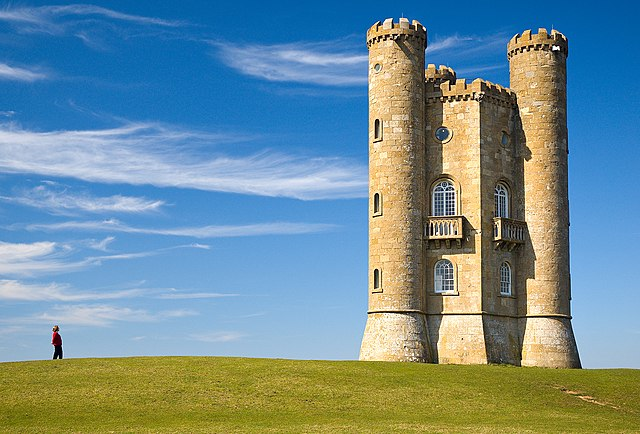

In [ ]:
show_pnm('./in.pnm')

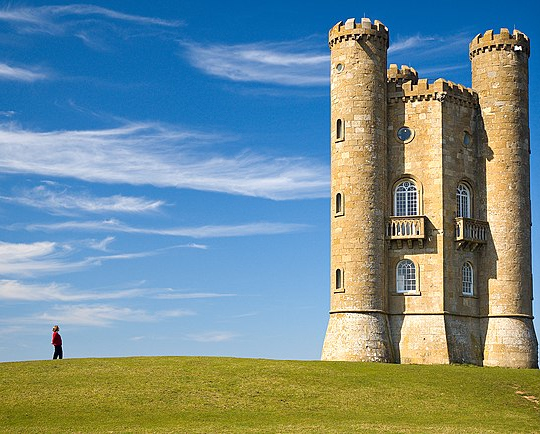

In [ ]:
show_pnm('./v1_host_out.pnm')


**2.2. Nh√¢n x√©t**

- ·∫¢nh thu ƒë∆∞·ª£c sau khi th·ª±c thi th√≠ nghi·ªám ƒë√∫ng v·ªõi y√™u c·∫ßu thu·∫≠t to√°n, ·∫£nh ƒë∆∞·ª£c thu nh·ªè, kh√¥ng  g√¢y bi·∫øn d·∫°ng ch·ªß th·ªÉ.
- Tuy nhi√™n th·ªùi gian th·ª±c thi m·∫•t nhi·ªÅu th·ªùi gian. Do ƒë√≥ vi·ªác song song h√≥a ch∆∞∆°ng tr√¨nh l√† ƒëi·ªÅu c·∫ßn thi·∫øt.




## IV. C√†i ƒë·∫∑t song song


### 1. Ph√¢n t√≠ch

Nh√≥m s·∫Ω song song h√≥a c√°c b∆∞·ªõc sau:

- B∆∞·ªõc 2. Chuy·ªÉn ƒë·ªïi t·ª´ RGB sang ·∫¢nh x√°m 
- B∆∞·ªõc 3. T√≠nh to√°n m·ª©c ƒë·ªô quan tr·ªçng c·ªßa t·ª´ng pixel
- B∆∞·ªõc 4. T√≠nh ma tr·∫≠n chi ph√≠ theo chi·ªÅu d·ªçc 
- B∆∞·ªõc 5. T√¨m Seam nh·ªè nh·∫•t
- B∆∞·ªõc 6. X√≥a Seam nh·ªè nh·∫•t

L√Ω do: 

- Ch∆∞∆°ng tr√¨nh l√†m vi·ªác v·ªõi d·ªØ li·ªáu l·ªõn (x·ª≠ l√Ω h√¨nh ·∫£nh). Thu·∫≠t to√°n seam carving ƒë∆∞·ª£c thi·∫øt k·∫ø ƒë·ªÉ th·ª±c hi·ªán song song tr√™n nhi·ªÅu d·ªØ li·ªáu ƒë·ªìng th·ªùi. S·ª≠ d·ª•ng CUDA gi√∫p t·∫≠n d·ª•ng hi·ªáu su·∫•t t√≠nh to√°n song song c·ªßa GPU ƒë·ªÉ x·ª≠ l√Ω d·ªØ li·ªáu l·ªõn nhanh ch√≥ng v√† hi·ªáu qu·∫£.

- C·∫ßn tƒÉng t·ªëc ƒë·ªô x·ª≠ l√Ω c·ªßa ch∆∞∆°ng tr√¨nh. CUDA cho ph√©p b·∫°n t·∫≠n d·ª•ng GPU ƒë·ªÉ th·ª±c hi·ªán c√°c t√°c v·ª• t√≠nh to√°n ph·ª©c t·∫°p, gi√∫p gi·∫£m th·ªùi gian ch·∫°y v√† tƒÉng t·ªëc ƒë·ªô x·ª≠ l√Ω so v·ªõi vi·ªác s·ª≠ d·ª•ng CPU truy·ªÅn th·ªëng.


### 2. Thi·∫øt k·∫ø

- **B∆∞·ªõc 2. Chuy·ªÉn ƒë·ªïi t·ª´ RGB sang ·∫¢nh x√°m:** th·ª±c hi·ªán chuy·ªÉn ƒë·ªïi m·ªôt h√¨nh ·∫£nh RGB (bao g·ªìm c√°c k√™nh m√†u: red, green, blue) th√†nh h√¨nh ·∫£nh x√°m (grayscale) theo c√¥ng th·ª©c:

> Y = 0.299R + 0.587G + 0.114B

- **B∆∞·ªõc 3. T√≠nh to√°n m·ª©c ƒë·ªô quan tr·ªçng c·ªßa t·ª´ng pixel:** ta c≈©ng s·ª≠ d·ª•ng grid v√† block 2 chi·ªÅu m·ªói thread s·∫Ω l√†m nhi·ªám v·ª• t√≠nh to√°n energy cho m·ªôt pixel tr√™n GrayScale b·∫±ng c√°ch d√πng edge detection v√† ghi v√†o m·∫£ng Energy.

- **B∆∞·ªõc 4. T√≠nh ma tr·∫≠n chi ph√≠ theo chi·ªÅu d·ªçc:** ·ªû thu·∫≠t to√°n tu·∫ßn t·ª± ƒë·ªÉ t√≠nh to√°n chi ph√≠ tr√™n d√≤ng `r` ph·∫£i c√≥ k·∫øt qu·∫£ d√≤ng `r + 1` m·ªõi t√≠nh ƒë∆∞·ª£c.  V√¨ v·∫≠y ta ch·ªâ c√≥ th·ªÉ c·∫ßn song song vi·ªác t√≠nh chi ph√≠ c·ªßa pixel tr√™n 1 d√≤ng v√† l·∫∑p l·∫°i tr√™n t·ª´ng d√≤ng. Ta s·∫Ω s·ª≠ d·ª•ng grid v√† block 1 chi·ªÅu, v√† m·ªói thread s·∫Ω l√†m nhi·ªÅu v·ª• t√≠nh gi√° tr·ªã c·ªßa 1 pixel.

- **B∆∞·ªõc 5. T√¨m Seam nh·ªè nh·∫•t:** T·ªëc ƒë·ªô x·ª≠ l√≠ t√¨m seam nh·ªè nh·∫•t tr√™n m·ªôt d√≤ng khi th·ª±c hi·ªán tu·∫ßn t·ª± kh√¥ng qu√° ch√¢m nh∆∞ng v·∫´n c√≥ th·ªÉ song song ƒë·ªÉ t·ªëi ∆∞u t·ªëc ƒë·ªô x·ª≠ l√≠. N√≥ s·ª≠ d·ª•ng thu·∫≠t to√°n bitonic sort, ƒë·ªÉ t√¨m gi√° tr·ªã nh·ªè nh·∫•t v√† ch·ªâ s·ªë t∆∞∆°ng ·ª©ng tr√™n  m·ªôt block, sau ƒë√≥ t√¨m gi√° tr·ªã nh·ªè nh·∫•t v√† ch·ªâ s·ªë t∆∞∆°ng ·ª©ng tr√™n to√†n b·ªô block .
- **B∆∞·ªõc 6. X√≥a Seam nh·ªè nh·∫•t:** Ta chia m·ªói pixel t·ª´ ·∫£nh Input cho 1 threard ƒë·ªÉ g√°n sang Ouput nh∆∞ng kh√¥ng g√°n nh·ªØng ƒë∆∞·ªùng seam.

### 3. ƒê√°nh gi√°

- ƒê·∫ßu v√†o v·∫´n l√† ·∫£nh c√≥ k√≠ch th∆∞·ªõc 640x434 v√† ·∫£nh ƒë·∫ßu ra c√≥ chi·ªÅu r·ªông gi·∫£m ƒëi 100px (540px). 
- Ta s·∫Ω l·∫•y k·∫øt qu·∫£ c·ªßa khi th·ª±c hi·ªán tu·∫ßn t·ª± l√†m chu·∫©n ƒë·ªÉ so s√°nh v·ªõi k·∫øt qu·∫£ th·ª±c hi·ªán song song.

In [ ]:
!nvcc -arch=sm_{major}{minor} SeamCarvingByDevice.cu -o SeamCarvingByDevice


In [ ]:
!./SeamCarvingByDevice in.pnm out_device.pnm 540


**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15835398144 byte
SMEM per SM: 65536 byte
SMEM per block: 49152 byte
****************************

Image size (width x height): 640 x 434

Seam carving by host
Time: 4729.762 ms

Seam carving by device
Time: 482.192 ms
Error: 0.000000


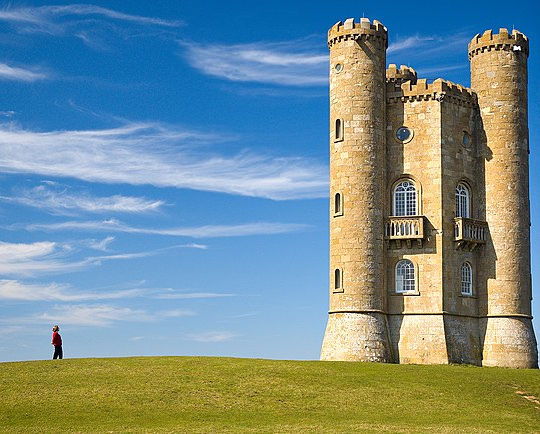

In [ ]:
show_pnm("out_device.pnm")


### Nh·∫≠n x√©t:

- ·∫¢nh ƒë·∫ßu ra c·ªßa khi th·ª±c hi·ªán song song ho√†n to√†n tr√πng kh·ªõp v·ªõi ·∫£nh ƒë·∫ßu ra khi th·ª±c hi·ªán tu·∫ßn t·ª±.
- So s√°nh th·ªùi gian x·ª≠ l√≠ 
  - Tu·∫ßn t·ª± x·ª≠ l√≠ trong **12915.335938 ms **
  - Song song x·ª≠ l√≠ trong **480.806 ms** 

>
> üåüüåüüåü **Th·ªùi gian x·ª≠ l√≠ nhanh h∆°n g·∫•p 27 l·∫ßn.** üåüüåüüåü
>

